In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import numpy
import torch.utils.data
from sklearn.model_selection import train_test_split

# Display Dataset

In [2]:
import sys
sys.path.append('..')

from Datasets.MackeyGlassDataset import MackeyGlassDataset
Mglass1 = MackeyGlassDataset(1000, 5, tau=17, seed=0)
Mglass2 = MackeyGlassDataset(10000, 2, tau=20, seed=0)

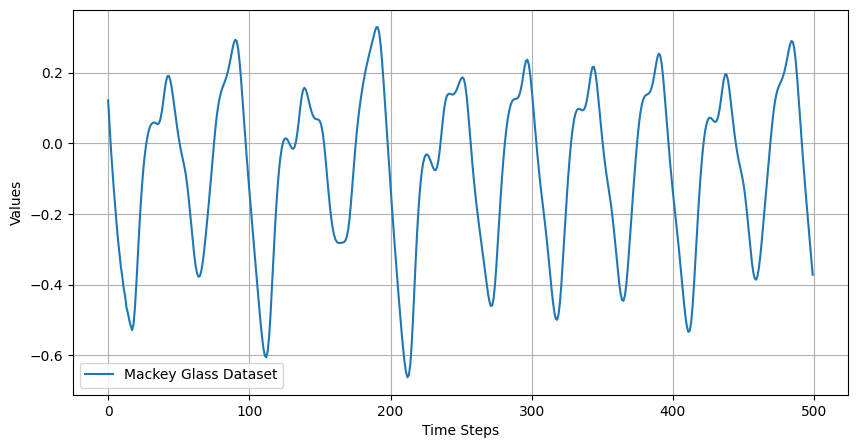

In [3]:
dataset = torch.utils.data.DataLoader(Mglass1, batch_size=1, shuffle=False)
dataset = np.array([data[0] for data in dataset]).reshape(-1, 1)
# loop through the input data (data[0]) and convert it to numpy array with shape of colomn vector

plt.figure(figsize=(10, 5))
plt.plot(dataset[:500], label='Mackey Glass Dataset')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('CPU is available')


GPU is available


# ESN 

In [5]:
from Models.Reservoir import Reservoir
from Models.Echostate import ESN

In [6]:
time = torch.linspace(0, 10, 1000)
inputs, targets = Mglass1[0]


# Normalize data to [-1, 1]
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min()) * 2 - 1
targets = (targets - targets.min()) / (targets.max() - targets.min()) * 2 - 1

print (inputs.shape, targets.shape)

# Split into train and test
train_data, test_data = inputs[:800], inputs[800:]

# Initialize ESN
Res = Reservoir(input_dim=1, reservoir_dim=300, output_dim=1, 
                spectral_radius=0.90, leak_rate=0.3)

ESN = ESN(input_dim=1, reservoir_dim=300, output_dim=1, 
            spectral_radius=0.90, leak_rate=0.3)

torch.Size([999, 1]) torch.Size([999, 1])


In [7]:
eigenvalues, _ = torch.linalg.eig(Res.W)  
λ_max = torch.max(torch.abs(eigenvalues))  
print(f"Actual λ_max after scaling: {λ_max.item()} (should match spectral radius {Res.spectral_radius})")

Actual λ_max after scaling: 0.9000033140182495 (should match spectral radius 0.9)


In [8]:
Res.train_readout(inputs,targets)
ESN.train_readout(inputs,targets)

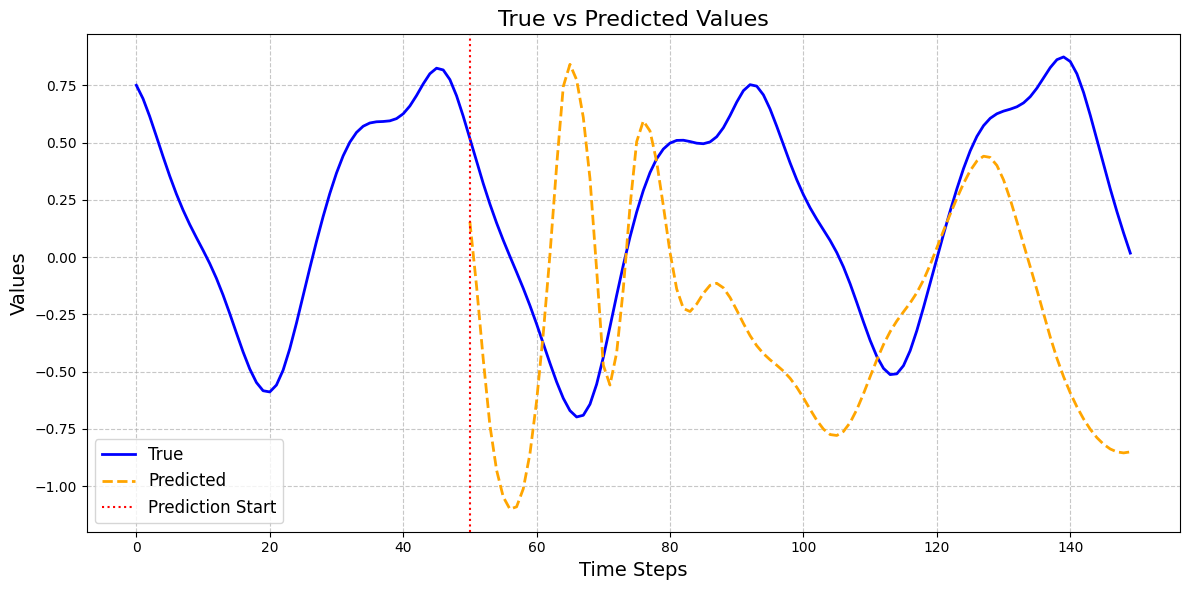

In [9]:
predictions = Res.predict(train_data[-1:], steps=100)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(torch.cat([train_data[-50:], test_data[:100]]).numpy(), label='True', color='blue', linewidth=2)
plt.plot(range(50, 150), predictions.numpy(), '--', label='Predicted', color='orange', linewidth=2)
plt.axvline(x=50, color='red', linestyle=':', label='Prediction Start', linewidth=1.5)
plt.title("True vs Predicted Values", fontsize=16)
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

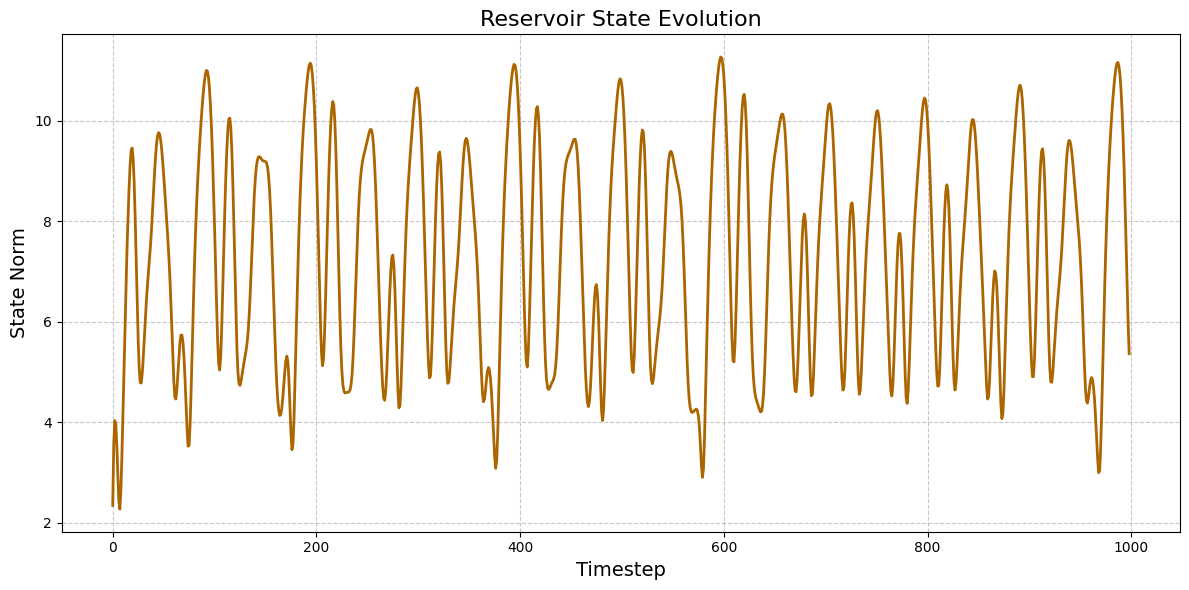

In [10]:
plt.figure(figsize=(12, 6))
plt.plot([state.norm().item() for state in Res.reservoir_states], color='#AC6600', linewidth=2)
plt.xlabel("Timestep", fontsize=14)
plt.ylabel("State Norm", fontsize=14)
plt.title("Reservoir State Evolution", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

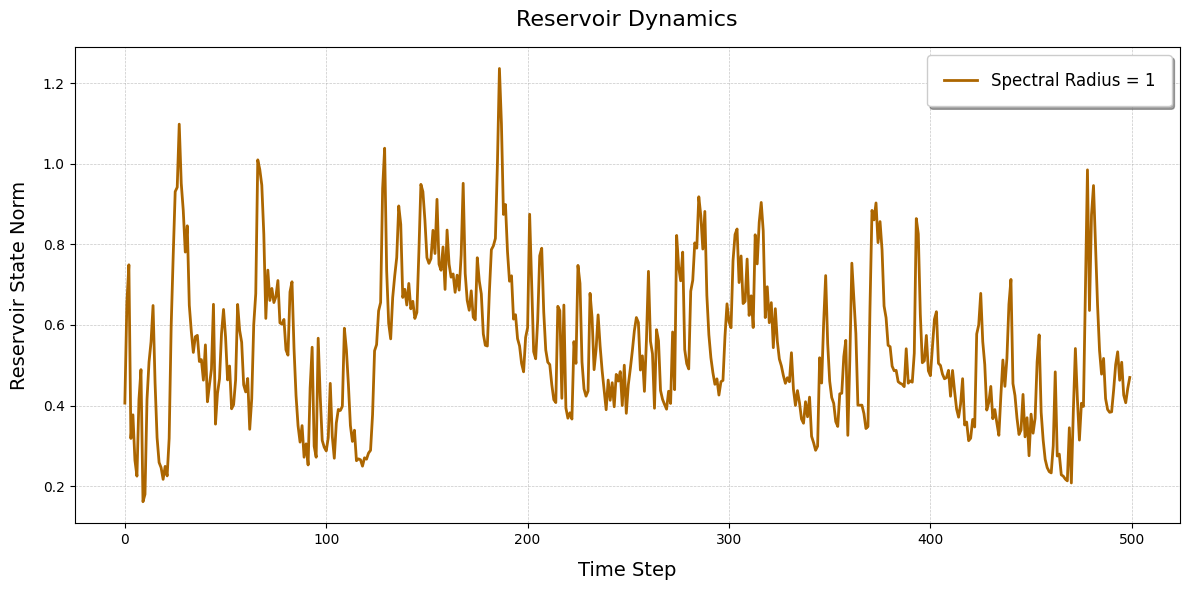

Approximate Lyapunov Exponent: -2.9955
Stable / Periodic Dynamics


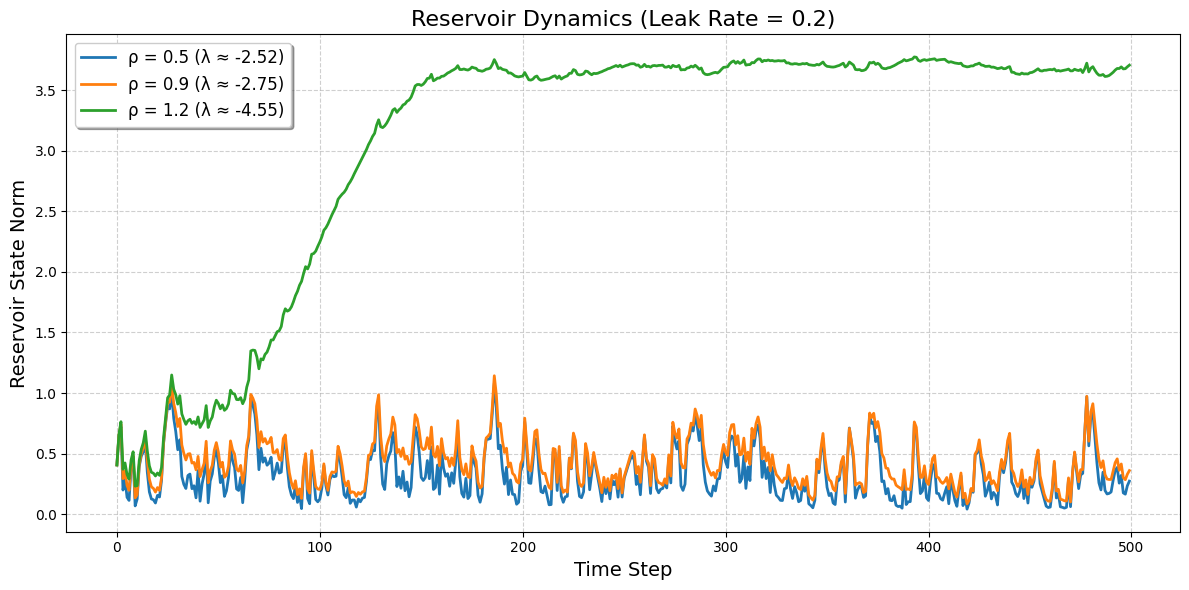

In [13]:
from HelperScripts.Testers import Test_lyapunov,Test_Spectral_radii
Test_lyapunov(spectral_radius=1)
Test_Spectral_radii()